In [398]:
# import scipy.io
import scipy as sc
import numpy as np
from ssmlearnpy import SSMLearn
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer

# data = np.load("Re8000/run1/UP_field_alldata.npy").squeeze()
# Create training dataset by iterating over all runs
trajectories = []
times = []
time = np.linspace(0, int(10000*0.005), 10000//20)
Re = 1000

# Iterate over multiple runs to create training dataset
# run_data = np.load(f"Re{Re}/run1/U_field_alldata.npy").squeeze()
# steady_state = np.mean(run_data, axis=1)
steady_state = np.load(f"Re{Re}/run1/U0_field_data.npy").squeeze()
V_coords = np.load(f"Re{Re}/run1/V_dof_coordinates.npy")
for run_idx in range(1, 5):  # Assuming runs 1-5, adjust as needed
    try:
        run_data = np.load(f"Re{Re}/run{run_idx}/U_field_alldata.npy").squeeze()
        trajectories.append((run_data-steady_state.reshape(-1,1))[:,0:])
        times.append(time[0:])  # Same time array for each run
        print(f"Loaded run {run_idx} with shape: {trajectories[run_idx-1].shape}")
    except FileNotFoundError:
        print(f"Run {run_idx} not found, skipping...")
        continue

print(f"Total trajectories loaded: {len(trajectories)}")

Loaded run 1 with shape: (83166, 500)
Loaded run 2 with shape: (83166, 500)
Loaded run 3 with shape: (83166, 500)
Loaded run 4 with shape: (83166, 500)
Total trajectories loaded: 4


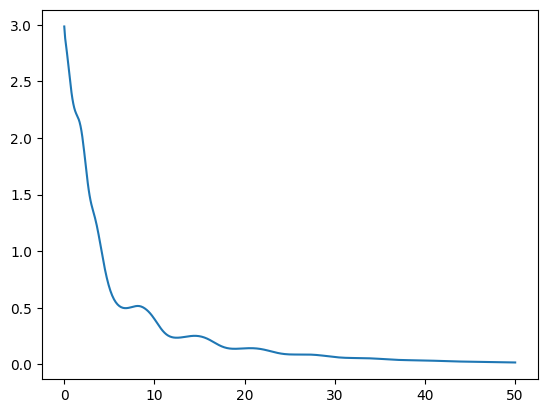

In [399]:
plt.plot(times[0], np.linalg.norm(trajectories[0], axis=0), label="Norms")

Grid resolution: 200x200
Domain: x=[0.000, 1.000], y=[0.000, 1.000]
Snapshot: -1


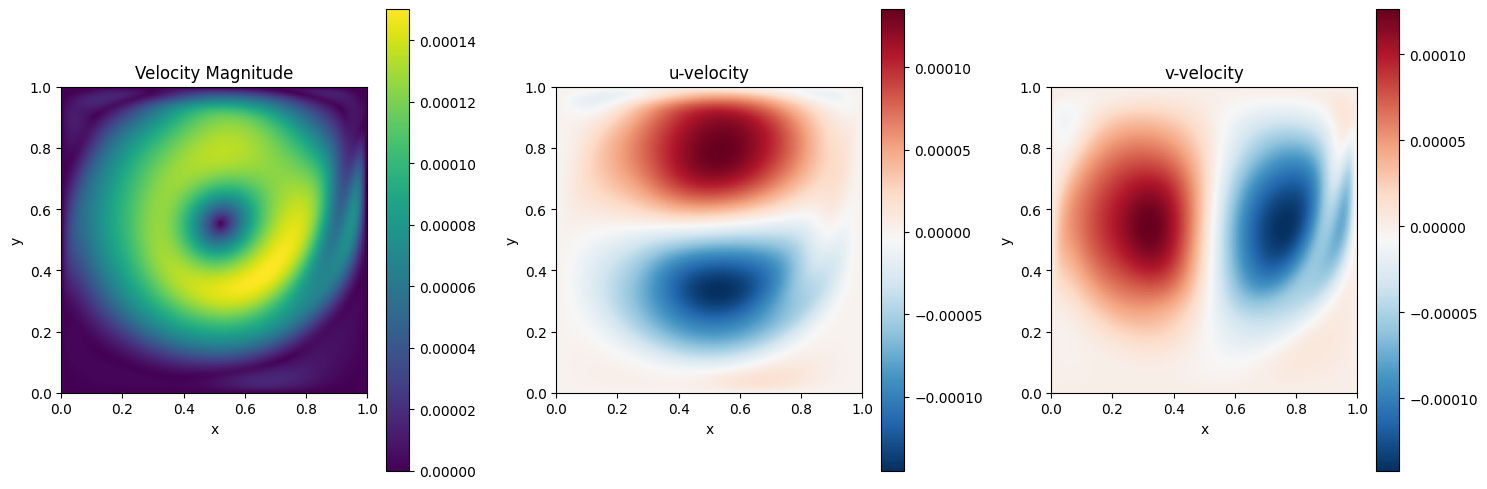

In [400]:
# In your notebook
import numpy as np
from pathlib import Path
from plot_utils import plot_velocity_fields, plot_velocity_magnitude_only

# Load data
# data_dir = Path("Re6000/run1")
# U_data = np.load(data_dir / "U_field_alldata.npy")
# U_data = np.load(f"Re{Re}/run1/U_field_alldata.npy")
# U_data = np.load(f"Re{Re}/run1/U0_field_data.npy")
U_data = trajectories[0]
# V_coords = np.load(data_dir / "V_dof_coordinates.npy")

# Plot all three velocity fields
fig, axes = plot_velocity_fields(U_data, V_coords, snapshot_idx=-1)
plt.show()

# # Or plot just velocity magnitude
# fig, ax = plot_velocity_magnitude_only(U_data, V_coords, snapshot_idx=0)
# plt.show()

In [465]:
from ssmlearnpy.utils.preprocessing import get_matrix
data_matrix = get_matrix(trajectories)
# POD modes:
U, s, v = np.linalg.svd(data_matrix, full_matrices = False)
dim_reduction = 2
red_basis = U[:, :dim_reduction]

In [484]:
from factor_analyzer import Rotator
num_factors = 3
projected_data = U[:, :num_factors].T @ data_matrix

rotator = Rotator(method='promax')
rotated_projections = rotator.fit_transform(projected_data.T)

rotation_matrix = rotator.rotation_
red_basis = (U[:, :num_factors]@ rotation_matrix)[:,:dim_reduction]

In [485]:
# # DMD Modes:
# V1 = data_matrix[:,:-1]
# V2 = data_matrix[:,1:]
# U, s, v = np.linalg.svd(V1, full_matrices = False)
# A_tilde = U.T @ V2 @ v.T @ np.diag(1/s)
# eigenvecs = np.linalg.eig(A_tilde)[1]
# dmd_modes = (U@eigenvecs)[:,:dim_reduction//2]
# red_basis = np.hstack([np.real(dmd_modes), np.imag(dmd_modes)])


In [486]:
red_basis

array([[ 6.94019159e-05,  8.85400805e-06],
       [ 6.82515622e-05,  8.71066855e-06],
       [ 6.51374506e-05,  8.30996529e-06],
       ...,
       [-2.59860582e-17, -3.31637602e-18],
       [ 7.89689128e-18,  1.00811166e-18],
       [-3.20939713e-17, -4.09600220e-18]])

In [487]:
def encode(x):
    return np.dot(red_basis.T, x)#/np.sqrt(s[:dim_reduction]).reshape(-1, 1)

In [488]:
red_coords = []

for traj in trajectories:
    red_coords.append(encode(traj))

In [489]:
ssm = SSMLearn(
    t = times,
    x = trajectories,
    reduced_coordinates=red_coords,
    ssm_dim=dim_reduction, 
    dynamics_type = 'flow',
    # dynamics_structure="normalform"
)

ssm.get_parametrization(poly_degree=1, fit_intercept=False)    
ssm.get_parametrization(poly_degree=2, fit_intercept=False) 
# ssm.get_reduced_dynamics(poly_degree=3)

INFO   2025-07-03 18:48:39 ridge Transforming data
INFO   2025-07-03 18:48:40 ridge Skipping CV on ridge regression
INFO   2025-07-03 18:48:40 ridge Using polynomial features degree 1
INFO   2025-07-03 18:48:40 ridge Fitting regression model
INFO   2025-07-03 18:48:43 ridge Transforming data
INFO   2025-07-03 18:48:44 ridge Skipping CV on ridge regression
INFO   2025-07-03 18:48:44 ridge Using polynomial features degree 2
INFO   2025-07-03 18:48:44 ridge Fitting regression model


In [490]:
from ssmlearnpy.utils.plots import Plot
## to force the plots to render
# might need to uncomment jupyterlab
import plotly.io as pio
pio.renderers.default='notebook'
# pio.renderers.default='jupyterlab'

plotter = Plot(
    label_observables = 'obs',
)

In [491]:
fig = plotter.make_plot(
    ssm, 
    data_name = 'observables', 
    idx_trajectories=[0], 
    idx_coordinates=[10000, 24000, 70000], 
    add_surface = True, 
)
fig.show()

In [492]:
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate
from ssmlearnpy.utils.ridge import get_fit_ridge
# X is list of len num_trajs, X[0] has shape (2,timesteps), same for y

X, y = shift_or_differentiate(
            ssm.emb_data['reduced_coordinates'], 
            ssm.emb_data['time'], 
            ssm.dynamics_type,
            accuracy=8
)

In [493]:
ssm.reduced_dynamics = get_fit_ridge(
        X,
        y,
        poly_degree=2, do_scaling = True,
)
linear_part = ssm.reduced_dynamics.map_info['coefficients'][:,:X[0].shape[0]]
d, v = np.linalg.eig(linear_part)
ssm.reduced_dynamics.map_info['eigenvalues_linear_part'] = d
ssm.reduced_dynamics.map_info['eigenvectors_linear_part'] = v

INFO   2025-07-03 18:48:49 ridge Transforming data
INFO   2025-07-03 18:48:49 ridge Skipping CV on ridge regression
INFO   2025-07-03 18:48:49 ridge Using polynomial features degree 2
INFO   2025-07-03 18:48:49 ridge Fitting regression model


In [494]:
ssm.reduced_dynamics.map_info['coefficients']


array([[-0.49926012, -1.06647981, -0.05394106,  0.48190362,  0.08505353],
       [ 0.51365833, -0.11900426, -0.00117315,  0.60991537,  0.08879099]])

In [495]:
test_index = 1
# v_init = trajectories[test_index][:,0]
etas = encode(trajectories[test_index])
eta_init = etas[:,0]
def forced_rhs(t, x):
    x = x.reshape(1,-1)
    return (ssm.reduced_dynamics.predict(x)).reshape(-1,1).squeeze()
t0 = times[test_index][0]
t_final = times[test_index][-1]

In [496]:
sol = sc.integrate.solve_ivp(forced_rhs, (t0, t_final), eta_init, t_eval=times[test_index], method="DOP853")

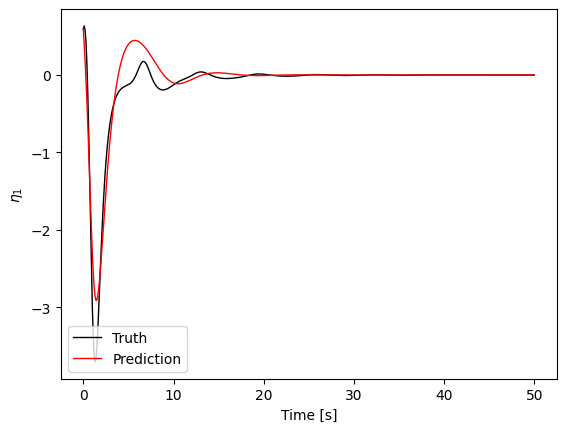

In [497]:
plt.figure()
plt.plot(times[test_index], etas[0,:], color="black", linewidth=1.0, label="Truth")
plt.plot(sol.t, sol.y[0,:], color="red", linewidth=1.0, label="Prediction")
plt.legend(loc="lower left")
plt.ylabel("$\eta_1$")
plt.xlabel("Time [s]")
plt.show()

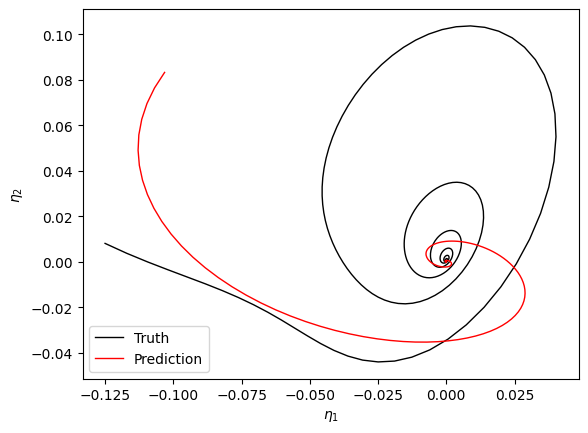

In [498]:
plt.figure()
start_idx = 100
plt.plot(etas[0,start_idx:], etas[1,start_idx:], color="black", linewidth=1, label="Truth")
plt.plot(sol.y[0,start_idx:], sol.y[1,start_idx:], color="red", linewidth=1, label="Prediction")
plt.legend(loc="lower left")
plt.xlabel("$\eta_1$")
plt.ylabel("$\eta_2$")
plt.show()